In [1]:
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
import tensorflow as tf

def main():
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    if tf.test.gpu_device_name():
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    else:
        print("Please install GPU version of TF")

if __name__ == "__main__":
    main()

Num GPUs Available:  0
Please install GPU version of TF


In [ ]:
# Dataset taken from: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

In [2]:
bounding_boxes = []
valid_filenames = []
# Loop over all XML files in the directory
for filename in os.listdir('plate_data/annotations'):
    if filename.endswith(".xml"):  # Check for file extension
        xml_path = os.path.join('plate_data/annotations', filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        # Check if there's exactly one object tag
        objects = root.findall('object')
        if len(objects) == 1:
            object_tag = objects[0]
            bndbox = object_tag.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bounding_boxes.append([xmin, ymin, xmax, ymax])
            valid_filenames.append(root.find('filename').text)
bounding_boxes = np.array(bounding_boxes)

In [4]:
print(bounding_boxes.shape)

(409, 4)


In [3]:
images = []
for filename in valid_filenames:
    img_path = os.path.join('plate_data/images', filename)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        images.append(img_array)

In [5]:
print(len(images))
print(images[5].shape)

409
(263, 350)


In [4]:
# check the min sizes of the images
min_size_x = 0
min_size_y = 0

for elem in images:
    if elem.shape[0] > min_size_x:
        min_size_x = elem.shape[0]
    if elem.shape[1] > min_size_y:
        min_size_y = elem.shape[1]

print(min_size_x)
print(min_size_y)

531
600


In [5]:
# function pad all image arrays to same size
def pad_image(image, target=(600,600)):
    pad_height = max(target[0] - image.shape[0], 0)  # Padding for height
    pad_width = max(target[1] - image.shape[1], 0)  # Padding for width

    padding = ((0, pad_height), (0, pad_width), (0, 0)) if image.ndim == 3 else ((0, pad_height), (0, pad_width))

    padded_image = np.pad(image, padding, mode='constant', constant_values=0)
    return padded_image

In [6]:
# add padding to all the images
for i in range(len(images)):
    images[i] = pad_image(images[i])

[198.   90.5 211.   95.5]


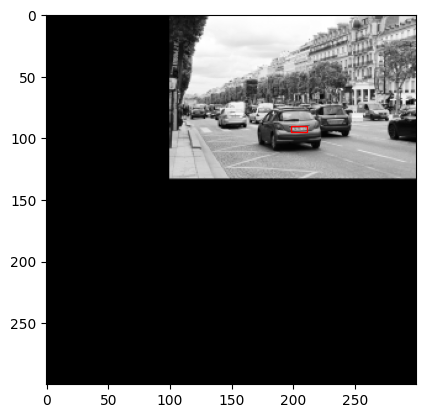

In [16]:
#plot the training images
image_index = 40

print(bounding_boxes[image_index])

fig, ax = plt.subplots(1)
# visualize the image
plt.imshow(images[image_index][:, :], cmap='gray')

x1 = int(bounding_boxes[image_index][0])
y1 = int(bounding_boxes[image_index][1])
x2 = int(bounding_boxes[image_index][2])
y2 = int(bounding_boxes[image_index][3])
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

#plt.axis('off')  # Hide the axis
plt.show()

In [8]:
images = np.array(images)
images = np.expand_dims(images, -1)
print(images.shape)

(409, 600, 600, 1)


In [9]:
def resize_images_in_batches(images, new_size=(320, 320), batch_size=100):
    num_images = images.shape[0]
    resized_images = np.empty((num_images, *new_size, 1), dtype=np.float32)  # Pre-allocate array
    
    for start in range(0, num_images, batch_size):
        end = start + batch_size
        batch_images = images[start:end]
        batch_images_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        resized_batch = tf.image.resize(batch_images_tensor, new_size).numpy() 
        resized_images[start:end] = resized_batch 
        
    return resized_images


images = resize_images_in_batches(images, new_size=(300, 300), batch_size=100)
bounding_boxes = bounding_boxes / 2

In [10]:
# flip some of the images to augment the data
W = 300  # Image width

for i in range(0, images.shape[0], 2):
    images[i] = np.flip(images[i], axis=1)
    x_min, y_min, x_max, y_max = bounding_boxes[i]
    bounding_boxes[i] = [W - x_max, y_min, W - x_min, y_max]

In [17]:
# normalize pixel values
images = images / 100

In [18]:
# normalize bounding box values
bounding_boxes = bounding_boxes / 100

In [19]:
print(bounding_boxes.shape)
print(images.shape)

(409, 4)
(409, 300, 300, 1)


In [20]:
# save the images array
np.savez("data_storage/images_np", images)

In [2]:
# load the images array
loaded_data = np.load("data_storage/images_np.npz")
images = np.array([loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))])
images = np.squeeze(images, axis=0)

In [21]:
# save the boxes array
np.savez("data_storage/boxes_np", bounding_boxes)

In [3]:
# load the boxes array
loaded_data = np.load("data_storage/boxes_np.npz")
bounding_boxes = np.array([loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))])
bounding_boxes = np.squeeze(bounding_boxes, axis=0)

In [10]:
images_train, images_val, boxes_train, boxes_val = train_test_split(
    images, bounding_boxes, test_size=0.25, random_state=42)

In [13]:
print(images_train.shape)

(306, 600, 600, 1)


In [11]:
def load_data(images, labels):
    for image, label in zip(images, labels):
        yield image, label

In [12]:
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_train, boxes_train),
    output_types=(images_train.dtype, boxes_train.dtype),
    output_shapes=([300, 300,1], [4])
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_val, boxes_val),
    output_types=(images_val.dtype, boxes_val.dtype),
    output_shapes=([300, 300,1], [4])
)

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False


# create the cnn model
model = tf.keras.Sequential([
    # Input layer for grayscale images
    layers.Input(shape=(300, 300, 1)),
    # Lambda layer to replicate the grayscale channel to simulate RGB
    layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3])),
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    # Output layer for bounding box (x, y, width, height)
    layers.Dense(4)
])

In [8]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [15]:
history = model.fit(
    train_dataset,  # Training data and labels
    epochs=10,  # Number of epochs to train for
    validation_data=validation_dataset  # Validation data and labels
)

Epoch 1/10
10/10 [==============================] - 206s 13s/step - loss: 151.0340 - mae: 4.4153 - val_loss: 0.1146 - val_mae: 0.3112
Epoch 2/10
10/10 [==============================] - 105s 10s/step - loss: 0.0585 - mae: 0.2015 - val_loss: 0.0165 - val_mae: 0.0971
Epoch 3/10
10/10 [==============================] - 99s 10s/step - loss: 0.0182 - mae: 0.1043 - val_loss: 0.0156 - val_mae: 0.0982
Epoch 4/10
10/10 [==============================] - 90s 9s/step - loss: 0.0122 - mae: 0.0842 - val_loss: 0.0136 - val_mae: 0.0884
Epoch 5/10
10/10 [==============================] - 97s 9s/step - loss: 0.0113 - mae: 0.0799 - val_loss: 0.0137 - val_mae: 0.0886
Epoch 6/10
10/10 [==============================] - 84s 8s/step - loss: 0.0108 - mae: 0.0786 - val_loss: 0.0158 - val_mae: 0.0979
Epoch 7/10
10/10 [==============================] - 98s 9s/step - loss: 0.0097 - mae: 0.0743 - val_loss: 0.0154 - val_mae: 0.0964
Epoch 8/10
10/10 [==============================] - 97s 10s/step - loss: 0.0094 - m

In [18]:
# save the trained model
model.save('trained_model/plate_recognizer_01.h5')

In [9]:
# load a saved model
from tensorflow.keras.models import load_model

#model = load_model('trained_model/plate_recognizer_01.h5')
model.load_weights('trained_model/plate_recognizer_01.h5')

In [14]:
# test the trained model

test_index = 25

test_image = np.expand_dims(images[test_index], axis=0)
predicted_box = model.predict(test_image)

predicted_box = np.squeeze(predicted_box, axis=0)

predicted_box = predicted_box * 300
test_image = test_image * 255
#predicted_box[0] = predicted_box[0] / 200.0
#predicted_box[0][3] = predicted_box[0][3] * -1.0
real_box = bounding_boxes[test_index] * 300

print(predicted_box)
print(real_box)
#predicted_box = real_box
# print(images_test.shape)
# print(boxes_test.shape)
fig, ax = plt.subplots(1)

# Display the original image
plt.imshow(np.squeeze(test_image, axis=0).astype('float32'), cmap='gray')  # Assuming this is already normalized and ready for display

# Create a Rectangle patch for the predicted bounding box
rect = patches.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2]-predicted_box[0], predicted_box[3]-predicted_box[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')  # Hide the axis
plt.show()


1/1 [==============================] - 1s 873ms/step
[-1862.1094   765.8203 -2728.125    577.7344]
[ 97.5  73.5 127.   84.5]
